# Steepest descent aplicado à função geofísica

Algoritmo de Steepest Descent aplicado a um problema geofísico para estimar o raio e a coordenada z da base de um prisma de base poligonal próximo de um cilindro.

# Importando pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
from visual import histeq
from fatiando import utils
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.vis import myv
from fatiando.gridder import regular

/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vital/anaconda2/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


# Funções para o prisma de base polygonal do fatiando

In [2]:
def pol2cart(l, M, L):
    '''
    This function transforms polar coordinates of the prisms
    into Cartesian coordinates and returns a list of polygonal
    prisms of the Fatiando a Terra.

    input

    l: list - each element is a list of [r, x0, y0, z1, z2, 'magnetization'],
              whrere r is an array with the radial distances of the vertices,
              x0 and y0 are the origin cartesian coordinates of each prism,
              z1 and z2 are the top and bottom of each prism and
              magnetization is physical property
    M: int - number of vertices per prism
    L: int - number of prisms

    output

    mk: list - list of objects of the class
    fatiando.mesher.PolygonalPrism
    '''

    lk = []
    r = np.zeros(M)  # it contains radial distances of the vertices in polar coordinates
    verts = [] # it contains radial distances of the vertices in Cartesian coordinates

    assert len(l) == L, 'The size of m and the number of prisms must be equal'

    for lv in l:
        assert len(lv[0]) == M, 'All prisms must have M vertices'

    ang = 2*np.pi/M # angle between two vertices

    for lv in l:
        r = lv[0]
        verts=[]
        for i in range(M):
            verts.append([r[i]*np.cos(i*ang) + lv[1], r[i]*np.sin(i*ang) + lv[2]])
        lk.append(PolygonalPrism(verts, lv[3], lv[4], lv[5]))

    return lk

def param2polyprism(m, M, L, z0, dz, props):
    '''
    Returns a lis of objects of the class
    fatiando.mesher.PolygonalPrism

    input

    m: 1D array - parameter vector
    M: int - number of vertices
    L: int - number of prisms
    z0: float - top of the model
    dz: float - thickness of each prism
    props: dictionary - physical property

    output

    mv: list - list of fatiando.mesher.PolygonalPrism
    '''
    P = L*(M + 2)
    assert m.size == P, 'The size of m must be equal to L*(M + 2)'
    for i in range(P):
        assert m[i:i+M].all >= 0., 'The radial distances must be positives'

    r = np.zeros(M) # vector for radial distances
    mv = [] # list of prisms

    k = 0.
    for i in range(0, P, M + 2):
        r = m[i:M+i]
        mv.append([r, m[i+M], m[i+M+1], z0 + dz*k, z0 + dz*(k + 1.), props])
        k = k + 1.

    mv = pol2cart(mv, M, L)

    return mv

# Modelagem direta

In [3]:
M = 10 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters

z0 = 100.    # depth of the top the shallowest prism
dz_true = 500.    # thickness of each prism

inc = -60.  # inclination
dec = 50.   # declination
intensity = 0.035 # intensity

props={'magnetization': utils.ang2vec(intensity, inc, dec)} # physical property: magnetization

r_true = 500.

r = np.zeros(M) + r_true # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, z0, z0 + dz_true, props]]   # list of parameters of the prisms

# criando os prismas do fatiando
prisms = pol2cart(l, M, L)

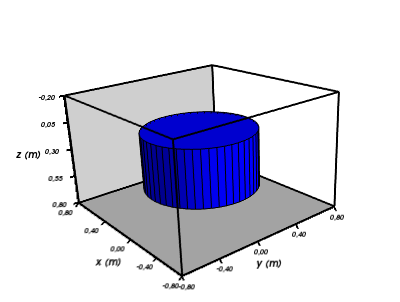

In [4]:
img(filename='bolacha.png')

# Pontos de observação

In [5]:
area = [-2000, 2000, -2000, 2000] #x minimum, x maximum, y minimum and y maximum
shape = (50,50) #number of data along the y and x directions
N = shape[0]*shape[1] #total number of data

#coordinates x and y of the data
xp, yp = regular(area, shape)

zp = np.zeros(N) - 100.

# Dados observados

In [6]:
data = polyprism.tf(xp, yp, zp, prisms, inc, dec) # predict data
amp_noise = 0.01*np.max(data)
data_noise = data + np.random.normal(loc=0., scale=amp_noise, size=shape[0]*shape[1]) # noise corrupted data

# Plot função desajuste

In [7]:
r_plot = np.linspace(100., 1000., 20)
dz_plot = np.linspace(10., 1000., 20)
r_plot,z0_plot = np.meshgrid(r_plot, dz_plot)
r_plot = r_plot.ravel()
dz_plot = z0_plot.ravel()
phi_plot = np.zeros_like(r_plot)

for i, (r, dz) in enumerate(zip(r_plot,dz_plot)):
    m = np.zeros(M) + r
    m = np.hstack((m,np.zeros(2)))
    l = param2polyprism(m, M, L, z0, z0 + dz, props)
    d_pred = polyprism.tf(xp, yp, zp, l, inc, dec)
    phi_plot[i] = np.sum((data - d_pred)**2)

r_plot = r_plot.reshape((20,20))
dz_plot = dz_plot.reshape((20,20))
phi_plot = phi_plot.reshape((20,20))

# equalizando as cores
phi_eq = histeq(phi_plot)
phi_eq = np.reshape(phi_eq,(20,20))
phi_eq = phi_eq

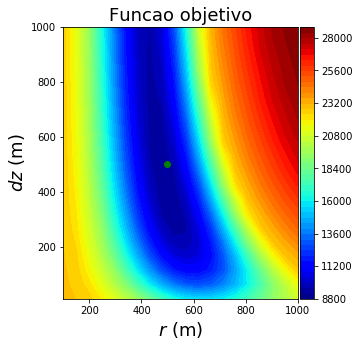

In [8]:
plt.figure(figsize=(5,5))
plt.plot(r_true, dz_true, 'og')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(r_plot, dz_plot, phi_eq, 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$dz$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

# Funções

In [9]:
def derivative_tf_z(xp, yp, zp, prism, M, deltaz, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of one fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    delta: float - increment in x coordinate in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - deltaa
    prism_plus[0].z2 += deltaz
    prism_minus[0].z2 -= deltaz

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltaz)

    return df

def derivative_tf_radiall(xp, yp, zp, prism, M, deltar, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of a fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in radial distance in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    ang = 2.*np.pi/M # angle between two vertices
    
    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - delta

    for i in range(M):
        deltax = deltar*np.cos(i*ang)
        deltay = deltar*np.sin(i*ang)
        prism_plus[0].x[i] += deltax
        prism_plus[0].y[i] += deltay
        prism_minus[0].x[i] -= deltax
        prism_minus[0].y[i] -= deltay

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltar)

    return df

# calculando jacobiana de phi
def jacobi_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec):
    '''
    Returns the sensitivity matrix for polygonal prisms using finite
    differences.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in meters for radial distance
    deltaz: float - increment in meters for depth
    inc: float - inclination of the local-geomagnetic field
    dec: declination of the local-geomagnetic field

    output

    G: 2D array - sensitivity matrix
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    G = np.zeros((xp.size, 2))

    G[:, 0] = derivative_tf_radiall(xp, yp, zp, prism[0], M, deltar, inc, dec)
    G[:, 1] = derivative_tf_z(xp, yp, zp, prism[0], M, deltaz, inc, dec)

    return G

# Modelo interpretativo

In [10]:
# chute inicial
p01 = 100.
p02 = 400.

# incremento para as derivadas
deltar = 0.01*p01
deltaz = 0.01*p02

r = np.zeros(M) + p01 # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

l = [[r, x0, y0, z0, z0 + p02, props]]

prism0 = pol2cart(l, M, L)

d0 = polyprism.tf(xp, yp, zp, prism0, inc, dec)

# vetor do chute inicial
p0 = np.array([p01,p02]) 

# parâmetros para o critério de Armijo
alfa = 0.0001
beta = 0.4

# critério de parada
epsilon = 0.00000001

# calculando o valor da função e do resíduo em p0
res0 = data_noise - d0
phi0 = np.sum(res0*res0)

# listas para armazenar as estimativas
p1_list = [p01]
p2_list = [p02]
phi_list = [phi0]

# iterações do algoritmo
itmax = 1000

# Algoritmo Steepest Descent

In [11]:
for i in range(itmax):
    # calculando a Jacobiana e o gradiente
    G = jacobi_geo(xp, yp, zp, prism0, M, deltar, deltaz, inc, dec)
    grad = -2.*np.dot(G.T, res0) + mi*p0
    #print grad
    # calculando p e atualizando para a próxima iteração
    p = p0 - lamb*grad
    #print p, p0
    l = [[np.zeros(M) + p[0], x0, y0, z0, z0 + p[1], props]]
    prism = pol2cart(l, M, L)
    d = polyprism.tf(xp, yp, zp, prism, inc, dec)
    res = data_noise - d
    phi = np.sum(res*res) + mi*np.dot(p0, p0)
    
    # printa os valores
    print 'itreação: %3d   r: %.2f   dz: %.2f   misfit: %.2e' % (i, p0[0], p0[1], phi0)
    
    # armazenando a última estimativa
    phi_list.append(phi)
    p1_list.append(p[0])
    p2_list.append(p[1])
    
    if (abs(phi - phi0)/phi0 <= epsilon):
        break
    else:
        # atualizando parâmetros
        p0 = p
        d0 = d
        res0 = res
        phi0 = phi
        prim0 = prism

itreação:   0   r: 109.40   z0: 400.60   misfit: 4.52e+03
itreação:   1   r: 119.45   z0: 401.32   misfit: 4.42e+03
itreação:   2   r: 130.17   z0: 402.15   misfit: 4.30e+03
itreação:   3   r: 141.52   z0: 403.11   misfit: 4.17e+03
itreação:   4   r: 153.49   z0: 404.22   misfit: 4.02e+03
itreação:   5   r: 166.03   z0: 405.49   misfit: 3.86e+03
itreação:   6   r: 179.09   z0: 406.93   misfit: 3.68e+03
itreação:   7   r: 192.61   z0: 408.53   misfit: 3.49e+03
itreação:   8   r: 206.53   z0: 410.31   misfit: 3.29e+03
itreação:   9   r: 220.76   z0: 412.26   misfit: 3.08e+03
itreação:  10   r: 235.23   z0: 414.38   misfit: 2.87e+03
itreação:  11   r: 249.84   z0: 416.64   misfit: 2.65e+03
itreação:  12   r: 264.50   z0: 419.05   misfit: 2.43e+03
itreação:  13   r: 279.13   z0: 421.57   misfit: 2.21e+03
itreação:  14   r: 293.62   z0: 424.19   misfit: 1.99e+03
itreação:  15   r: 307.89   z0: 426.88   misfit: 1.79e+03
itreação:  16   r: 321.84   z0: 429.61   misfit: 1.59e+03
itreação:  17 

# Plots de resultados

In [12]:
res_norm = (res - np.mean(res))/np.std(res)
res_plot = res.reshape(shape)
xp = xp.reshape(shape)
yp = yp.reshape(shape)
dpred = data.reshape(shape)
dobs = data_noise.reshape(shape)

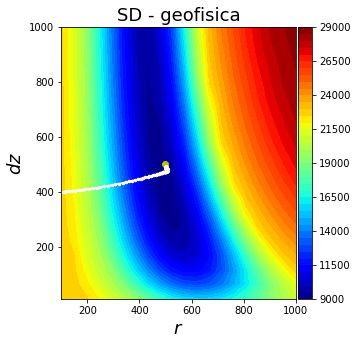

In [13]:
#plot
plt.figure(figsize=(5,5))
plt.plot(r_true, dz_true, 'oy')
plt.plot(p1_list, p2_list, '.w-', markersize=5)
plt.title('SD - geofisica', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet')
plt.xlabel('$r$', fontsize=18)
plt.ylabel('$dz$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

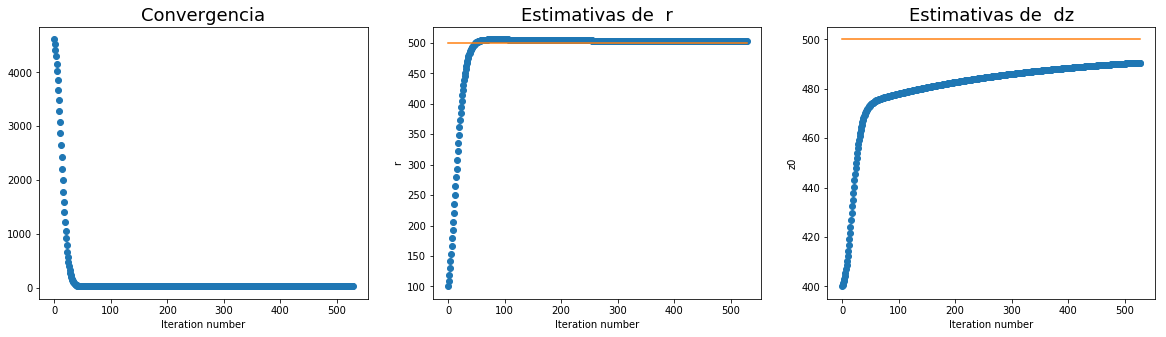

In [14]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Convergencia', fontsize = 18)
plt.xlabel('Iteration number')
plt.plot(phi_list, 'o')

plt.subplot(1, 3, 2)
plt.title('Estimativas de  r', fontsize = 18)
plt.xlabel('Iteration number')
plt.ylabel('r')
plt.plot(p1_list, 'o')
plt.plot(np.zeros(len(p1_list)) + r_true, '-')

plt.subplot(1, 3, 3)
plt.title('Estimativas de  dz', fontsize = 18)
plt.xlabel('Iteration number')
plt.ylabel('z0')
plt.plot(p2_list, 'o')
plt.plot(np.zeros(len(p1_list)) + dz_true, '-')
plt.show()

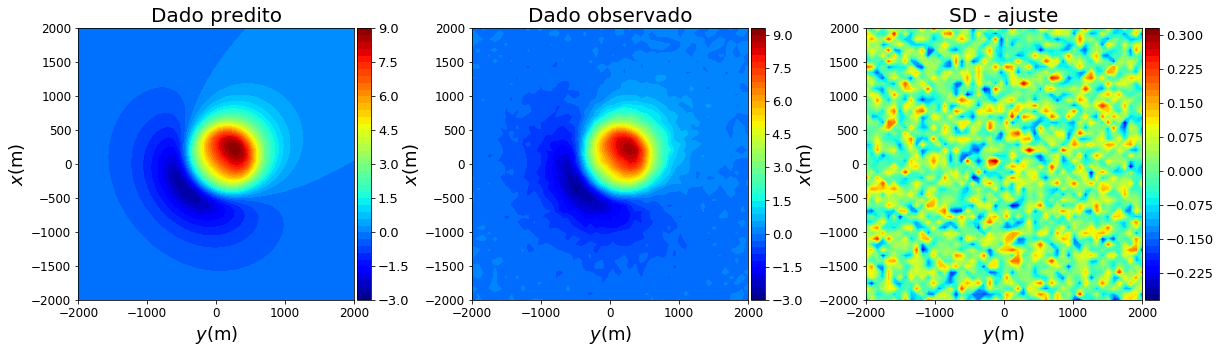

In [15]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=20)
plt.contourf(yp, xp, dpred, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=20)
plt.contourf(yp, xp, dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 3)
plt.title('SD - ajuste', fontsize=20)
plt.contourf(yp, xp, res_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)
plt.show()

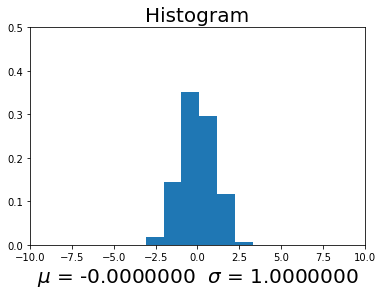

In [16]:
plt.plot(figsize=(20,5))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
plt.hist(res_norm,bins=nbins, normed=True)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.show()